In [29]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [30]:
# Binance API endpoint for historical data
api_url = 'https://api.binance.com/api/v3/klines'

# Parameters for the API request (Bitcoin, 1 day interval, 1000 data points)
params = {
    'symbol': 'BNBUSDT',
    'interval': '3d',
    'limit': 10000
}

# Send GET request to Binance API
response = requests.get(api_url, params=params)
data = response.json()

# Extracting relevant data from the API response
df = pd.DataFrame(
    data, columns=[
        'openTime',
        'open',
        'high',
        'low',
        'close',
        'volume',
        'closeTime',
        'quoteAssetVolume',
        'numberOfTrades',
        'takerBuyBaseAssetVolume',
        'takerBuyQuoteAssetVolume',
        'ignore'
    ]
)

# Renaming columns for clarity
df.columns = [
    'Open Time',
    'Open',
    'High',
    'Low',
    'Close',
    'Volume',
    'Close Time',
    'Quote Asset Volume', 
    'Number of Trades',
    'Taker Buy Base Asset Volume',
    'Taker Buy Quote Asset Volume',
    'Ignore'
]


df.drop(
    ['Close Time',
    'Quote Asset Volume',
    'Number of Trades',
    'Taker Buy Base Asset Volume',
    'Taker Buy Quote Asset Volume', 
    'Ignore'],
    axis=1, inplace=True
)

# Converting timestamps to datetime format
df['Open Time'] = pd.to_datetime(df['Open Time'], unit='ms')

# Converting columns to numeric for further manipulation
cols = df.columns.drop('Open Time')
cols
df[cols] = df[cols].apply(pd.to_numeric)



In [31]:
prices = df['Close'].values.reshape(-1,1)

# Normalize data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)


In [32]:
# Define train and test set sizes
train_size = int(len(scaled_prices) * 0.8)
test_size = len(scaled_prices) - train_size

# Split data into train and test sets
train_data = scaled_prices[:train_size]
test_data = scaled_prices[train_size:]


In [33]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i : (i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Define sequence length (number of time steps to look back)
seq_length = 30

# Create sequences for training data
X_train, y_train = create_sequences(train_data, seq_length)

# Create sequences for test data
X_test, y_test = create_sequences(test_data, seq_length)


In [34]:
# Define LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(X_train, y_train, epochs=50, batch_size=32)


/home/nurlan/projects/crypto_prediction/binance/bitcoin_using_RF/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0619
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0105
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0075
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0057
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0056
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0049
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0043
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0038
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0038
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0030
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0025
Epoch 13/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0029
Epoch 14/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0032
Epoch 15/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0022
Epoc

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


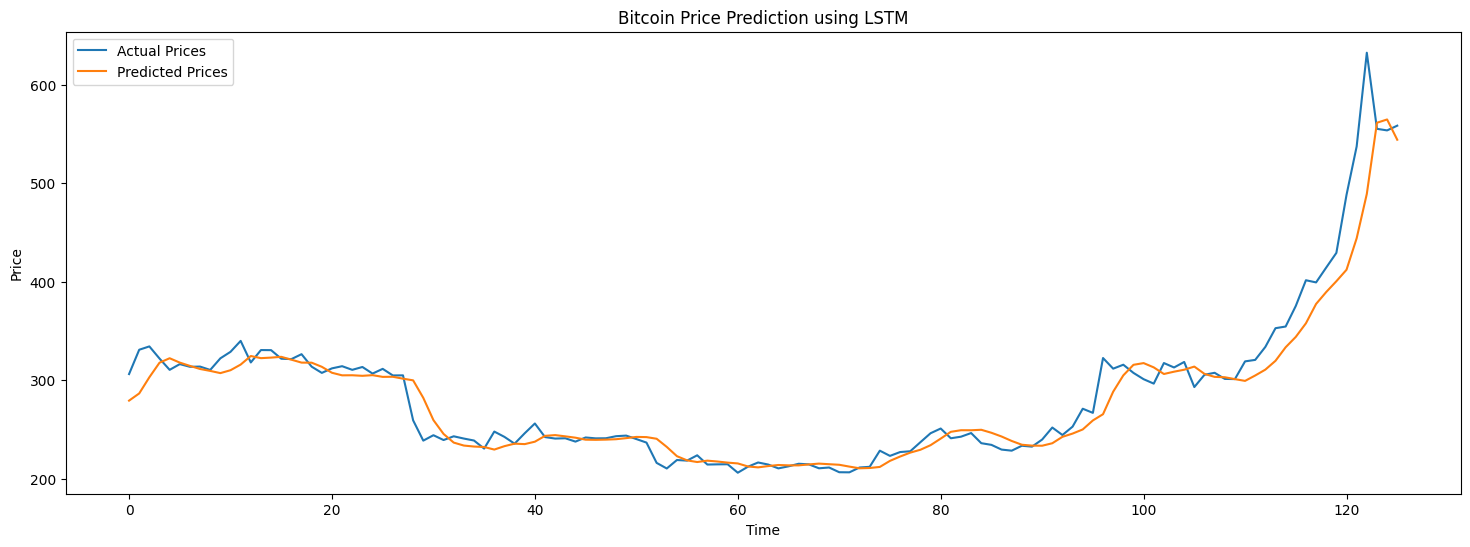

In [35]:
# Generate predictions for test data
predictions = model.predict(X_test)

# Inverse transform predictions and actual values
predictions = scaler.inverse_transform(predictions)
actual_values = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted prices
plt.figure(figsize=(18, 6))
plt.plot(actual_values, label='Actual Prices')
plt.plot(predictions, label='Predicted Prices')
plt.title('Bitcoin Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [36]:
# Calculate MAE
mae = mean_absolute_error(actual_values, predictions)

# Calculate MSE
mse = mean_squared_error(actual_values, predictions)

# Calculate R2 score
r2 = r2_score(actual_values, predictions)

# Calculate RMSE
rmse = np.sqrt(mse)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R2 Score: {r2}")
print(f"RMSE: {rmse}")


MAE: 12.455124967060398
MSE: 494.37548498336
R2 Score: 0.9200487485439501
RMSE: 22.234556100434297
